# House Price Prediction (Multiple Regression Models)

This notebook compares multiple regression models to predict house prices:
- Linear Regression
- Ridge & Lasso
- Random Forest

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [49]:
print("train data shape:",train.shape)
print("test data shape:",test.shape)

train data shape: (1460, 81)
test data shape: (1459, 80)


In [50]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Exploring the data and feature engineering

In [51]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

skew is: 1.8828757597682129


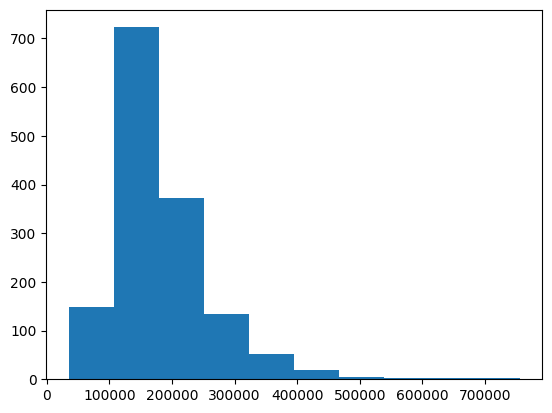

In [52]:
print("skew is:",train.SalePrice.skew())
plt.hist(train.SalePrice)
plt.show()

now skew is: 0.12133506220520406


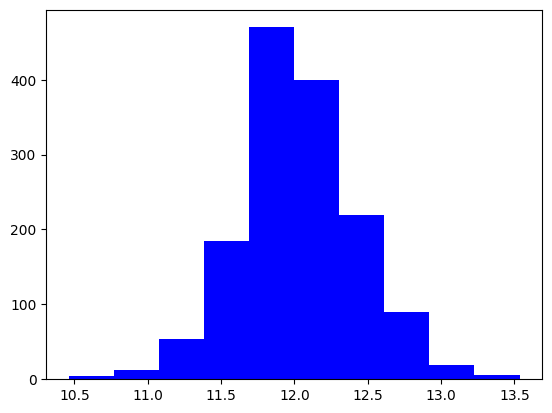

In [53]:
target=np.log(train.SalePrice)
print("now skew is:",target.skew())
plt.hist(target,color='blue')
plt.show()

In [54]:
numeric_features=train.select_dtypes(include=[np.number])
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [55]:
corr=numeric_features.corr()
print(corr['SalePrice'].sort_values(ascending=False)[:5],'\n')
print(corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [56]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [57]:
quality_pivot=train.pivot_table(index='OverallQual',values='SalePrice',aggfunc=np.median)
quality_pivot

/tmp/ipykernel_15874/2059187465.py:1: FutureWarning: The provided callable <function median at 0x7f79cc778220> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  quality_pivot=train.pivot_table(index='OverallQual',values='SalePrice',aggfunc=np.median)


,SalePrice
OverallQual,
1,50150.0
2,60000.0
3,86250.0
4,108000.0
5,133000.0
6,160000.0
7,200141.0
8,269750.0
9,345000.0


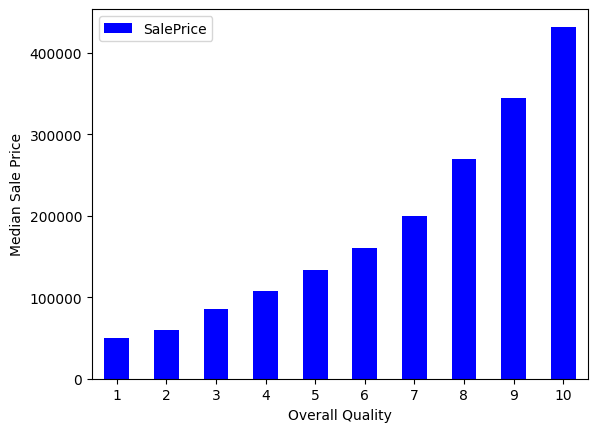

In [58]:
quality_pivot.plot(kind='bar',color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

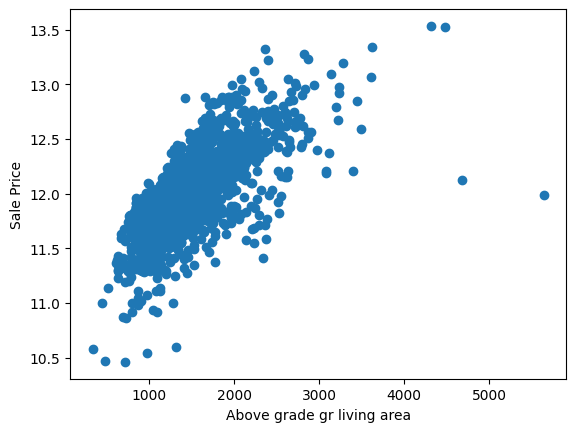

In [59]:
plt.scatter(x=train['GrLivArea'],y=target)
plt.ylabel('Sale Price')
plt.xlabel('Above grade gr living area')
plt.show()

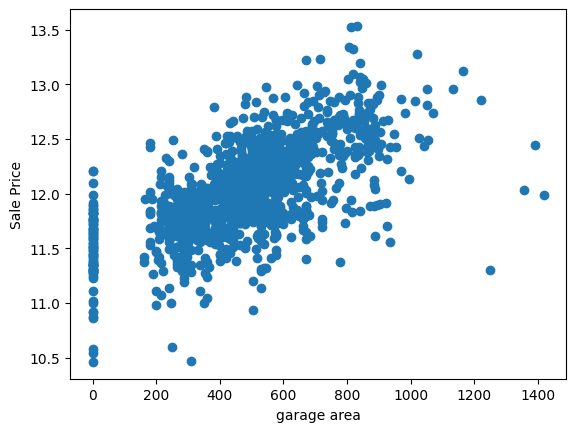

In [60]:
plt.scatter(x=train['GarageArea'],y=target)
plt.ylabel('Sale Price')
plt.xlabel('garage area')
plt.show()

In [61]:
train=train[train['GarageArea']<1200]   

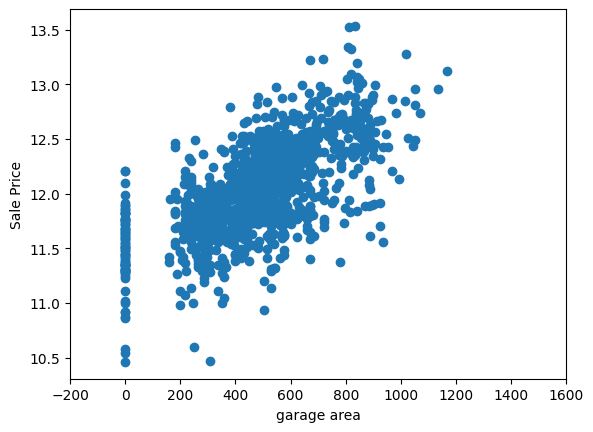

In [62]:
plt.scatter(x=train['GarageArea'],y=np.log(train.SalePrice))
plt.xlim(-200,1600)
plt.ylabel('Sale Price')
plt.xlabel('garage area')
plt.show()

In [63]:
nulls=pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns=['Null Count']
nulls.index.name='Feature'
nulls

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
MasVnrType,871
FireplaceQu,689
LotFrontage,258
GarageQual,81
GarageFinish,81


In [64]:
print("Unique values are:",train.MiscFeature.unique())

Unique values are: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [65]:
categories=train.select_dtypes(exclude=[np.number])
categories.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1455,1455,91,1455,1455,1455,1455,1455,1455,1455,...,1374,1374,1374,1374,1455,6,281,53,1455,1455
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,1147,1450,50,921,1309,1454,1048,1378,225,1257,...,867,605,1306,1321,1335,2,157,48,1266,1196


In [66]:
print("Original:\n")
print(train.Street.value_counts())

Original:

Street
Pave    1450
Grvl       5
Name: count, dtype: int64


In [67]:
train['enc_street']=pd.get_dummies(train.Street,drop_first=True)
test['enc_street']=pd.get_dummies(train.Street,drop_first=True)

In [68]:
print(train.enc_street.value_counts())

enc_street
True     1450
False       5
Name: count, dtype: int64


/tmp/ipykernel_15874/210829686.py:1: FutureWarning: The provided callable <function median at 0x7f79cc778220> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  condition_pivot=train.pivot_table(index='SaleCondition',values='SalePrice',aggfunc=np.median)


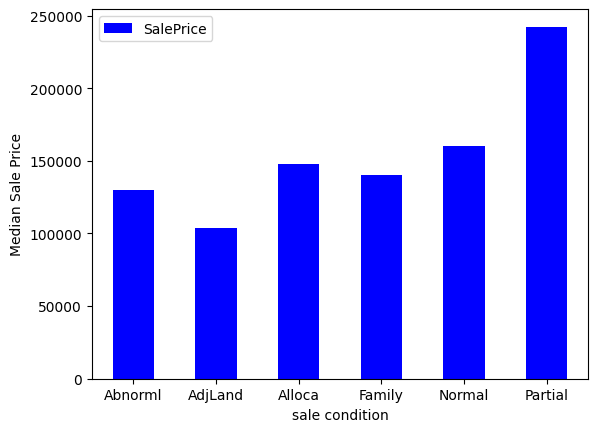

In [69]:
condition_pivot=train.pivot_table(index='SaleCondition',values='SalePrice',aggfunc=np.median)
condition_pivot.plot(kind='bar',color='blue')
plt.xlabel("sale condition")
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [70]:
def encode(x):
    return 1 if x=='Partial' else 0
train['enc_condition']=train.SaleCondition.apply(encode)
test['enc_condition']=train.SaleCondition.apply(encode)

/tmp/ipykernel_15874/478682649.py:1: FutureWarning: The provided callable <function median at 0x7f79cc778220> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  condition_pivot=train.pivot_table(index='enc_condition',values='SalePrice',aggfunc=np.median)


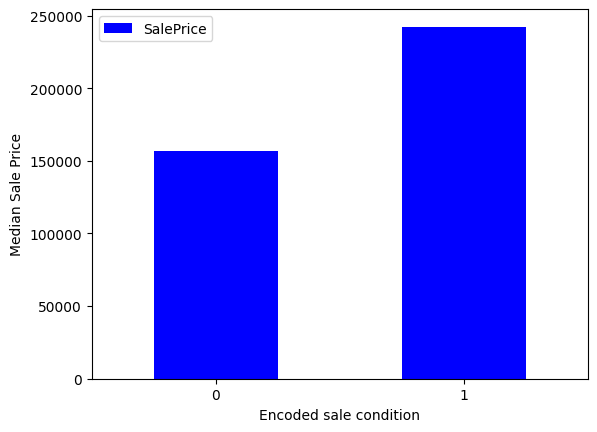

In [71]:
condition_pivot=train.pivot_table(index='enc_condition',values='SalePrice',aggfunc=np.median)
condition_pivot.plot(kind='bar',color='blue')
plt.xlabel("Encoded sale condition")
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [72]:
data=train.select_dtypes(include=[np.number]).interpolate().dropna()

In [73]:
sum(data.isnull().sum()!=0)

0

Building a linear model

In [74]:
y=np.log(train.SalePrice)
X=data.drop(['SalePrice','Id'],axis=1)

In [75]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=.33)

Begin modelling

In [76]:
from sklearn import linear_model
lr=linear_model.LinearRegression()

In [77]:
model=lr.fit(X_train,y_train)

Evaluating the performance and visualizing the results

In [78]:
print("R^2 is :\n",model.score(X_test,y_test))

R^2 is :
 0.888350909966633


In [79]:
predictions=model.predict(X_test)

In [80]:
from sklearn.metrics import mean_squared_error
print("Linear Regression RMSE:\n",mean_squared_error(y_test,predictions))

Linear Regression RMSE:
 0.017825327863102494


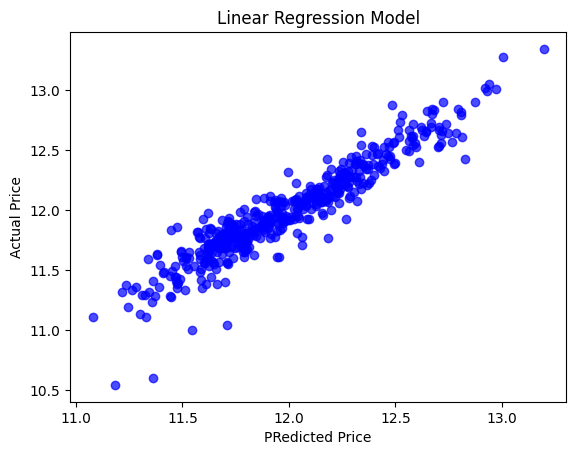

In [81]:
actual_values=y_test
plt.scatter(predictions,actual_values,alpha=.7,color='b')
plt.xlabel('PRedicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

using various models

In [82]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming you already have X_train, X_test, y_train, y_test

models = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.17f}")


Ridge Regression RMSE: 0.13353071856093457
Lasso Regression RMSE: 0.16046813885865316
Random Forest RMSE: 0.13940474344644424


RMSE Comparison

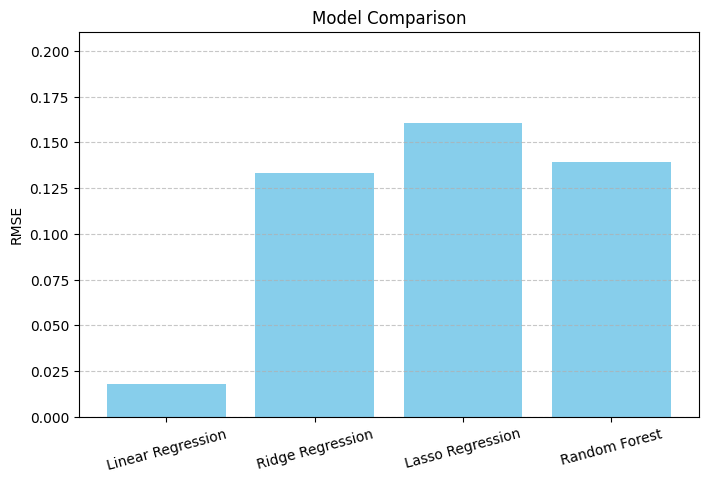

In [83]:
import matplotlib.pyplot as plt

rmse_scores = {
    "Linear Regression": 0.0178,
    "Ridge Regression": 0.1335,
    "Lasso Regression": 0.1604,
    "Random Forest": 0.1394
}

plt.figure(figsize=(8, 5))
plt.bar(rmse_scores.keys(), rmse_scores.values(), color='skyblue')
plt.ylabel("RMSE")
plt.title("Model Comparison")
plt.ylim(0, max(rmse_scores.values()) + 0.05)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [84]:
submission=pd.DataFrame()
submission['Id']=test.Id

In [85]:
feats=test.select_dtypes(include=[np.number]).drop(['Id'],axis=1).interpolate()

In [86]:
predictions=model.predict(feats)

In [87]:
final_predictions=np.exp(predictions)

In [88]:
print("Original predictions are:\n",predictions[:5],"\n")
print("Final predictions are:\n",final_predictions[:5])

Original predictions are:
 [11.78704319 11.97751428 12.11449371 12.10652562 12.16375962] 

Final predictions are:
 [131536.96422274 159135.97053074 182497.8571509  181049.47595781
 191713.93587694]
